 **変数の意味**

- state : あがりに必要な枚数の手牌の状態

- hand : stateから一枚切った状態

- hist : stateやhandをヒストグラムで表したもの（長さが牌種のリスト）

- kind_tile : 用いる牌の種類数

- num_hand : 手牌の枚数

- NUM_SANE_TILE : 同一牌の枚数(基本的に4で固定)


0=1m, 1=2m, ... , 7=8m, 8=9m, 9=1p, 10=2p, ... ,16=8p, 17=9p, 18=1s, 19=2s, ... ,25=8s, 26=9s, 27=東, ... , 33=中

In [3]:
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import time

random_seed = 0
np.random.seed(random_seed)

### 必要な関数の再定義

In [4]:
def is_valid(seq, NUM_SAME_TILE=4): # 生成された組み合わせが手牌として妥当かどうかを判断する関数　tuple(seq)の一つ一つが一つの状態(手牌)に対応している
    counts = defaultdict(lambda: 0)
    for i in range(0, len(seq)):
        if i + 1 < len(seq) and seq[i] > seq[i + 1]: # 前半の条件はiが一番最後以外は常に成立、後半の条件は昇順に整列するための条件
            return False
        counts[seq[i]] += 1
        if (counts[seq[i]] > NUM_SAME_TILE): return False # 牌の上限枚数を超えたらFalse
    return True
    
def generate_all_l(kind_tile, num_hand, NUM_SAME_TILE=4): # 全ての手牌の組み合わせをタプルで出力する関数
    gen_list = []
    for seq in itertools.product(range(kind_tile), repeat=num_hand):
        if is_valid(seq, NUM_SAME_TILE):
            gen_list.append(seq)
    return gen_list

def state2hist(state, kind_tile): # 手牌(state)を、牌種ごとの枚数のリスト(長さkind_tile)に変換する関数
    hist = [0] * kind_tile # hist = [0,0,...,0]
    for tile in state:
        hist[tile] += 1
    return hist

def states2hists(state_list, kind_tile): # 手牌(state)のリストを、牌種ごとの枚数のリストに変換する関数
    hist_list = []
    for state in state_list:
        #print(state)
        hist = [0] * kind_tile # hist = [0,0,...,0]
        for tile in state:
            hist[tile] += 1
        hist_list.append(hist)
    return hist_list

def state2hist_for_win(state, NUM_KIND_TILES=34): # あがり判定のために牌種の間には0を入れたhistを生成する関数
    hist = [0] * (NUM_KIND_TILES + 9) # hist = [0,0,...,0]
    for tile in state:
        if tile <= 8: # 萬子
            hist[tile] += 1
        elif tile <= 17: # 筒子
            hist[tile + 1] += 1
        elif tile <= 26: # 索子
            hist[tile + 2] += 1
        else: # 字牌
            hist[30 + (tile - 27) * 2] += 1
    return hist

def win_split_sub(hist, two, three, split_state, agari_list):
    if any(x < 0 for x in hist):
        return
    if two == 0 and three == 0:
        agari_list.append(tuple(split_state))
        return
    i = next(i for i, x in enumerate(hist) if x > 0) # histの中でx>０を満たす最小のindexを持ってくる
    next_hist = [x - 2 if i == j else x for j, x in enumerate(hist)]
    if two > 0 and hist[i] == 2: # 雀頭
        win_split_sub(next_hist, two - 1, three, split_state + [(i, i)], agari_list)
    next_hist = [x - 3 if i == j else x for j, x in enumerate(hist)]
    if three > 0 and hist[i] == 3: # 刻子
        win_split_sub(next_hist, two, three - 1, split_state + [(i, i, i)], agari_list)
    next_hist = [x -1 if i <= j <= i + 2 else x for j, x in enumerate(hist)]
    if three > 0 and i + 2 < len(hist): # 順子
        win_split_sub(next_hist, two, three - 1, split_state + [(i, i+1, i+2)], agari_list)
    return 
    
def win_split_main(hist): # あがり判定
    n_two = 1 if sum(hist) % 3 == 2 else 0
    n_three = sum(hist) // 3
    agari_list = []
    win_split_sub(hist, n_two, n_three, [], agari_list)
    if len(agari_list) == 0:
        return (False, set())
    else:
        return (True, agari_list)

def is_tanyao(state):
    for hai in state:
        if hai == 0 or hai == 8:
            return False
    return True

def is_chanta(split_state):
    state_value = True
    for block in split_state:
        if 0 in block or 8 in block:
            continue
        else:
            state_value = False
            break
    return state_value

def is_toitoi(split_state):
    state_value = True
    for block in split_state:
        if len(block) == 2: # 雀頭
            continue
        else:  # 面子
            if block[0] != block[1]:
                state_value = False
                break
    return state_value
    
def is_ipeko(split_state):
    for block in split_state:
        if len(block) == 2:
            continue
        if block[0] != block[1]:
            temp = list(split_state)
            temp.remove(block)
            if block in temp:
                return True
    return False

def hist2onehot(hist, kind_tile, NUM_SAME_TILE=4): # 手牌１つをサイズ(kind_tile, NUM_SAME_TILE)の行列にする
    matrix = np.zeros(shape=(kind_tile, NUM_SAME_TILE))
    for i, num in enumerate(hist):
        if num == 0:
            continue
        else:
            matrix[i][:num] = 1
    return matrix

def hists2onehots(hist_list, kind_tile, NUM_SAME_TILE=4): # 手牌1つ1つをone_hot形式に直す
    onehots = np.zeros((len(hist_list), kind_tile, NUM_SAME_TILE))
    for i in range(len(hist_list)):
        for j, hist_i in enumerate(hist_list[i]):
            if hist_i == 0:
                continue
            else:
                onehots[i][j][:hist_i] = 1
    return onehots

### 教師データの作成

In [5]:
# データの作成時のみ動かす（サイズが小さい時）
kind_tile = 9
num_hand = 5
NUM_SAME_TILE = 4

state_list = generate_all_l(kind_tile, num_hand, NUM_SAME_TILE)
state_hist_list = states2hists(state_list, kind_tile)

is_win_list = []
for state_hist in state_hist_list:
    is_win_list.append(win_split_main(state_hist)[0])
    
np.save('data/state_list_{}_{}'.format(kind_tile, num_hand), np.array(state_list))
np.save('data/is_win_list_{}_{}'.format(kind_tile, num_hand), np.array(is_win_list))

In [28]:
# データの作成時のみ動かす（サイズが大きい時）
NUM_KIND_TILES = 34
kind_tile = 34
num_hand = 14
NUM_SAME_TILE = 4
num_states = 1000000 # 教師データのサイズ
win_rate = 0.3

state_list = []
is_win_list = []
for i in range(num_states):
    if np.random.rand() < win_rate: # あがりの形をtrue_rateの割合で生成
        while(True):
            state = []
            for j in range(4): # 面子を追加
                if np.random.rand() < 0.3: # 刻子
                    tile = np.random.randint(0, kind_tile)
                    for l in range(3):
                        state.append(tile)
                else:
                    while(True):
                        tile = np.random.randint(0, min(kind_tile, 25))
                        if not tile in (7, 8, 16, 17):
                            break
                    for l in range(3):
                        state.append(tile + l)
            tile = np.random.randint(0, kind_tile) # 雀頭
            for m in range(2):
                state.append(tile)
            is_valid = True # 5枚以上同じ牌を使っていないか判定
            for tile in state:
                if state.count(tile) >= 5:
                    is_valid = False
                    break
            if is_valid:
                break
    else:
        all_tile = np.array([i for i in range(kind_tile) for j in range(NUM_SAME_TILE)])
        state = np.random.permutation(all_tile)[:num_hand].tolist()
        
    # 牌譜から生成するのも案
    # 教師データの確率分布が実際の分布と一致するようにするべき（比率の調整は要るだろう）
    # これで実際の牌譜で評価するのは？
    # ミニ麻雀の強化学習の牌譜を使って
    # 13枚の手牌を入力で、各牌があがりかどうかの二値分類で学習（二乗誤差）
    
    state = tuple(sorted(state))
    #print(state)
    hist = state2hist_for_win(state, NUM_KIND_TILES)
    #print(hist)
    state_list.append(state)
    is_win_list.append(win_split_main(hist)[0])
    #print(win_split_main(hist)[0])
    
np.save('data/state_list_{}_{}_{}_{}'.format(kind_tile, num_hand, num_states, win_rate), np.array(state_list))
np.save('data/is_win_list_{}_{}_{}_{}'.format(kind_tile, num_hand, num_states, win_rate), np.array(is_win_list))

0で穴埋めすると実際のサイズより大きくなる

m          9 -> 9

m, p       18 -> 19

m, p, t    25 -> 33

m, p, s    27 -> 29

m, p, s, t 34 -> 43

実際にやるのは萬子のみと全種類くらい？

### 教師あり学習

In [1]:
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.models import load_model

def dense_train(kind_tile, num_hand, epochs, x_path, y_path):
    NUM_SAME_TILE = 4
    input_shape = (kind_tile, NUM_SAME_TILE)
    
    # モデルの定義
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

    # モデルのコンパイル
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

    x = np.load(x_path)
    y = np.load(y_path)
    x_hists = states2hists(x, kind_tile)
    x_onehots = hists2onehots(x_hists, kind_tile)
    x_train, x_test, y_train, y_test = train_test_split(x_onehots, y, test_size=0.3, random_state=random_seed)

    history = model.fit(x = x_train,
                        y = y_train,
                        epochs = epochs,
                        validation_data = (x_test, y_test), 
                       )

    # モデルの保存
    model.save('models/dense_{}_{}.h5'.format(kind_tile, num_hand))
    return history

def draw_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)

    fig = plt.figure()
    fig1 = fig.add_subplot(111)
    fig1.plot(epochs, acc, 'bo', label='Training acc')
    fig1.plot(epochs, val_acc, 'b', label='Validation acc')

    fig1.set_xlabel('epochs')
    fig1.set_ylabel('accuracy')
    fig.legend(bbox_to_anchor=(0., 0.19, 0.86, 0.102), loc=5)# anchor（凡例）の第２引数がx、第３引数がy

    fig.savefig('draw_pdf/acc_{}_{}_{}epo.pdf'.format(kind_tile, num_hand, len(acc)))
    plt.show()
    
def draw_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    fig = plt.figure()
    fig1 = fig.add_subplot(111)
    fig1.plot(epochs, loss, 'bo', label='Training loss')
    fig1.plot(epochs, val_loss, 'b', label='Validation loss')
    #fig1.title('Training and validation loss')a

    fig1.set_xlabel('epochs')
    fig1.set_ylabel('loss')
    fig.legend(bbox_to_anchor=(0., 0.73, 0.86, 0.102), loc=5)# anchor（凡例）の第２引数がy、第３引数がx

    fig.savefig('draw_pdf/loss_{}_{}_{}epo.pdf'.format(kind_tile, num_hand, len(loss)))
    plt.show()

Using TensorFlow backend.


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 136)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               35072     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 68,097
Trainable params: 68,097
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 7s 95us/step - loss: 0.1417 - acc: 0.9415 - val_loss: 0.0530 - val_acc: 0.9801
Epoch 2/10
70000/70000 [==============================] - 6s 

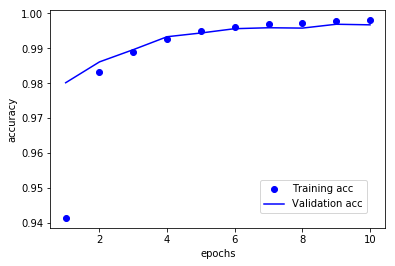

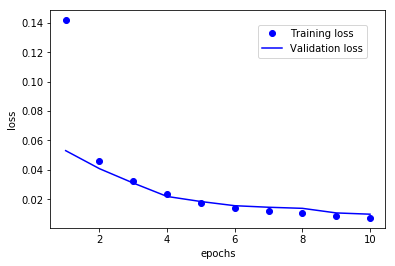

In [43]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_{}_{}_100000_0.3.npy'.format(kind_tile, num_hand)
y_path = 'data/is_win_list_{}_{}_100000_0.3.npy'.format(kind_tile, num_hand)
history = dense_train(kind_tile, num_hand, 10, x_path, y_path)
draw_acc(history)
draw_loss(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               9472      
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 42,497
Trainable params: 42,497
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 30000 samples
Epoch 1/10
70000/70000 [==============================] - 5s 66us/step - loss: 0.4698 - acc: 0.7816 - val_loss: 0.4309 - val_acc: 0.8005
Epoch 2/10
70000/70000 [==============================] - 5s 

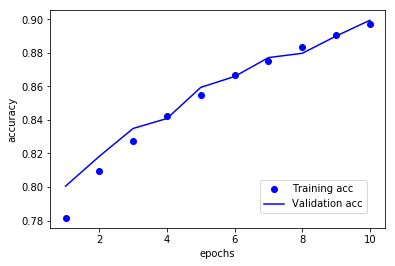

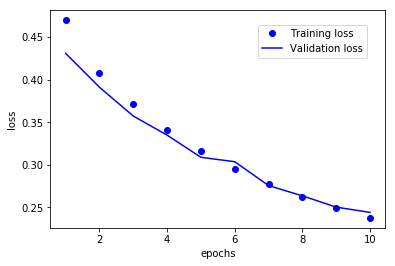

In [15]:
kind_tile = 9
num_hand = 14
x_path = 'data/state_list_{}_{}_100000_0.3.npy'.format(kind_tile, num_hand)
y_path = 'data/is_win_list_{}_{}_100000_0.3.npy'.format(kind_tile, num_hand)
history = dense_train(kind_tile, num_hand, 10, x_path, y_path)
draw_acc(history)
draw_loss(history)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 136)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               35072     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 68,097
Trainable params: 68,097
Non-trainable params: 0
_________________________________________________________________
Train on 76484 samples, validate on 32779 samples
Epoch 1/10
76484/76484 [==============================] - 5s 71us/step - loss: 0.1180 - acc: 0.9761 - val_loss: 0.1132 - val_acc: 0.9757
Epoch 2/10
76484/76484 [==============================] - 6s 

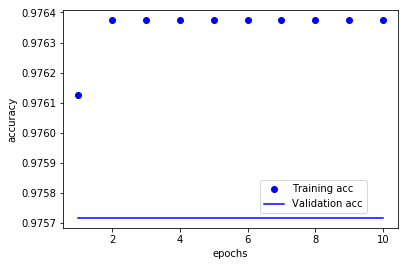

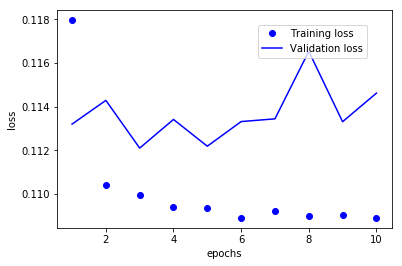

In [16]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_tenho_109263.npy'
y_path = 'data/is_win_list_tenho_109263.npy'
history = dense_train(kind_tile, num_hand, 10, x_path, y_path)
draw_acc(history)
draw_loss(history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 136)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               35072     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 68,097
Trainable params: 68,097
Non-trainable params: 0
_________________________________________________________________
Train on 83374 samples, validate on 35733 samples
Epoch 1/10
83374/83374 [==============================] - 7s 78us/step - loss: 0.4414 - acc: 0.8081 - val_loss: 0.4113 - val_acc: 0.8097
Epoch 2/10
83374/83374 [==============================] - 6s 

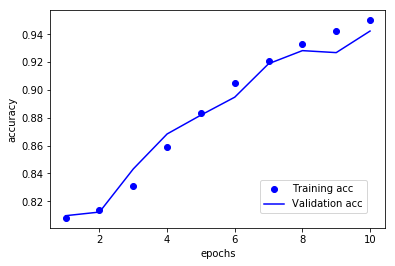

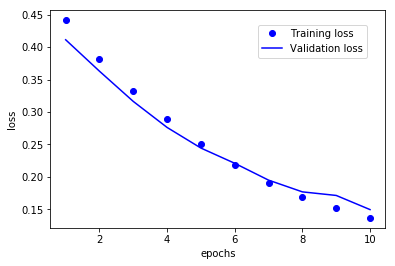

In [29]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_tenho_119107.npy'
y_path = 'data/is_win_list_tenho_119107.npy'
history = dense_train(kind_tile, num_hand, 10, x_path, y_path)
draw_acc(history)
draw_loss(history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 136)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               35072     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 68,097
Trainable params: 68,097
Non-trainable params: 0
_________________________________________________________________
Train on 162508 samples, validate on 69647 samples
Epoch 1/10
162508/162508 [==============================] - 13s 78us/step - loss: 0.4634 - acc: 0.8119 - val_loss: 0.4480 - val_acc: 0.8130
Epoch 2/10
162508/162508 [==============================]

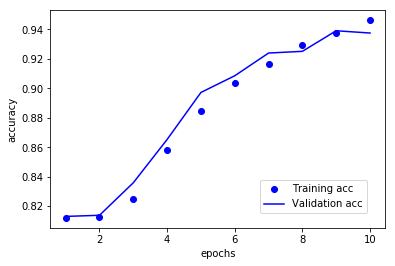

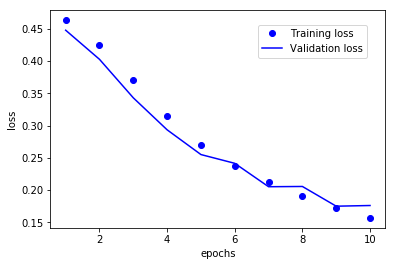

In [31]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_tenho_232155.npy'
y_path = 'data/is_win_list_tenho_232155.npy'
history = dense_train(kind_tile, num_hand, 10, x_path, y_path)
draw_acc(history)
draw_loss(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 136)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               70144     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 201,729
Trainable params: 201,729
Non-trainable params: 0
_________________________________________________________________

Train on 162508 samples, validate on 69647 samples
Epoch 1/10
162508/162508 [==============================] - 24s 150us/step - loss: 0.4473 - acc: 0.8125 - val_loss: 0.4129 - val_acc: 0.8145
Epoch 2/10
162508/162508 [===========================

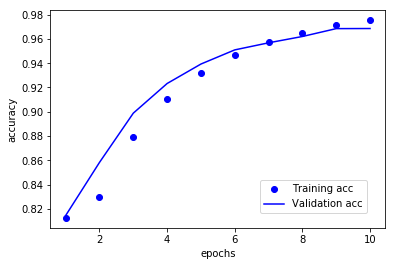

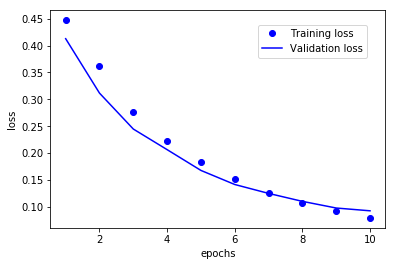

In [5]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_tenho_232155.npy'
y_path = 'data/is_win_list_tenho_232155.npy'
history = dense_train(kind_tile, num_hand, 10, x_path, y_path)
draw_acc(history)
draw_loss(history)

In [51]:
def dense_train_ver2(kind_tile, num_hand, num_epochs, x_path, y_path):
    
    NUM_SAME_TILE = 4
    input_shape = (kind_tile, NUM_SAME_TILE)
    dense_list = [128, 256, 512]
    x = np.load(x_path)
    y = np.load(y_path)
    x_hists = states2hists(x, kind_tile)
    x_onehots = hists2onehots(x_hists, kind_tile)
    x_train, x_test, y_train, y_test = train_test_split(x_onehots, y, test_size=0.3, random_state=random_seed)

    fig = plt.figure()
    fig1 = fig.add_subplot(111)
    fig1.set_xlabel('epochs')
    fig1.set_ylabel('accuracy')
    
    for dense in dense_list:
        # モデルの定義
        model = models.Sequential()
        model.add(layers.Flatten(input_shape=input_shape))
        model.add(layers.Dense(dense, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.summary()

        # モデルのコンパイル
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

        history = model.fit(x = x_train,
                            y = y_train,
                            epochs = num_epochs,
                            validation_data = (x_test, y_test), 
                           )

        # モデルの保存
        #model.save('models/dense_{}_{}.h5'.format(kind_tile, num_hand))

        acc = history.history['acc']
        val_acc = history.history['val_acc']
        epochs = range(1, len(acc) + 1)
        if dense == 512:
            train_acc_color = 'bo'
            val_acc_color = 'b'
        elif dense == 256:
            train_acc_color = 'go'
            val_acc_color = 'g'
        else:
            train_acc_color = 'ro'
            val_acc_color = 'r'
        fig1.plot(epochs, acc, train_acc_color, label='Train acc ({})'.format(dense))
        fig1.plot(epochs, val_acc, val_acc_color,label='Valid acc ({})'.format(dense))


    fig.legend(bbox_to_anchor=(0., 0.26, 0.895, 0.102), loc=5)# anchor（凡例）の第２引数がy、第３引数がx

    fig.savefig('draw_pdf/dense_acc_{}_{}_{}epo.pdf'.format(kind_tile, num_hand, len(acc)))
    plt.show()
    

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_61 (Flatten)         (None, 136)               0         
_________________________________________________________________
dense_172 (Dense)            (None, 128)               17536     
_________________________________________________________________
dense_173 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 129       
Total params: 34,177
Trainable params: 34,177
Non-trainable params: 0
_________________________________________________________________
Train on 162508 samples, validate on 69647 samples
Epoch 1/10
162508/162508 [==============================] - 18s 110us/step - loss: 0.4679 - acc: 0.8123 - val_loss: 0.4528 - val_acc: 0.8130
Epoch 2/10
162508/162508 [=============================

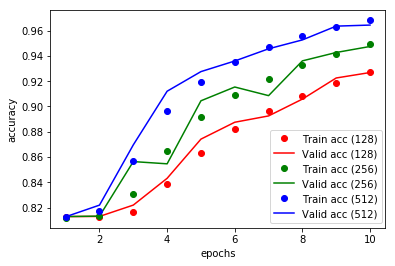

In [52]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_tenho_232155.npy'
y_path = 'data/is_win_list_tenho_232155.npy'
history = dense_train_ver2(kind_tile, num_hand, 10, x_path, y_path)
#(0., 0.26, 0.90, 0.102)

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_46 (Flatten)         (None, 136)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 128)               17536     
_________________________________________________________________
dense_137 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 129       
Total params: 34,177
Trainable params: 34,177
Non-trainable params: 0
_________________________________________________________________
Train on 162508 samples, validate on 69647 samples
Epoch 1/2
162508/162508 [==============================] - 14s 87us/step - loss: 0.4675 - acc: 0.8125 - val_loss: 0.4540 - val_acc: 0.8130
Epoch 2/2
162508/162508 [==============================] 

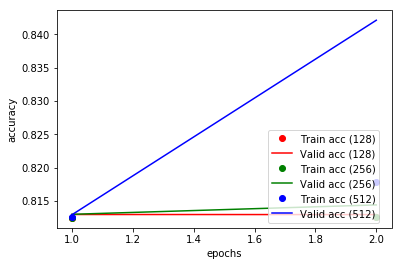

In [38]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_tenho_232155.npy'
y_path = 'data/is_win_list_tenho_232155.npy'
history = dense_train_ver2(kind_tile, num_hand, 2, x_path, y_path)
#(0., 0.26, 0.89, 0.102)

In [48]:
def dense_train_ver3(kind_tile, num_hand, num_epochs, x_path, y_path):
    
    NUM_SAME_TILE = 4
    input_shape = (kind_tile, NUM_SAME_TILE)
    dense_list = [64, 128, 256]
    x = np.load(x_path)
    y = np.load(y_path)
    x_hists = states2hists(x, kind_tile)
    x_onehots = hists2onehots(x_hists, kind_tile)
    x_train, x_test, y_train, y_test = train_test_split(x_onehots, y, test_size=0.3, random_state=random_seed)

    fig = plt.figure()
    fig1 = fig.add_subplot(111)
    fig1.set_xlabel('epochs')
    fig1.set_ylabel('accuracy')
    
    for dense in dense_list:
        # モデルの定義
        model = models.Sequential()
        model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', input_shape=input_shape))
        model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
        model.add(layers.Flatten())
        model.add(layers.Dense(dense, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.summary()

        # モデルのコンパイル
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

        history = model.fit(x = x_train,
                            y = y_train,
                            epochs = num_epochs,
                            validation_data = (x_test, y_test), 
                           )

        # モデルの保存
        #model.save('models/dense_{}_{}.h5'.format(kind_tile, num_hand))

        acc = history.history['acc']
        val_acc = history.history['val_acc']
        epochs = range(1, len(acc) + 1)
        if dense == 256:
            train_acc_color = 'bo'
            val_acc_color = 'b'
        elif dense == 128:
            train_acc_color = 'go'
            val_acc_color = 'g'
        else:
            train_acc_color = 'ro'
            val_acc_color = 'r'
        fig1.plot(epochs, acc, train_acc_color, label='Train acc ({})'.format(dense))
        fig1.plot(epochs, val_acc, val_acc_color,label='Valid acc ({})'.format(dense))

    fig.legend(bbox_to_anchor=(0., 0.26, 0.895, 0.102), loc=5)# anchor（凡例）の第２引数がy、第３引数がx

    fig.savefig('draw_pdf/conv1d_acc_{}_{}_{}epo.pdf'.format(kind_tile, num_hand, len(acc)))
    plt.show()
    

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 34, 64)            832       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 34, 64)            12352     
_________________________________________________________________
flatten_58 (Flatten)         (None, 2176)              0         
_________________________________________________________________
dense_166 (Dense)            (None, 64)                139328    
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 65        
Total params: 152,577
Trainable params: 152,577
Non-trainable params: 0
_________________________________________________________________
Train on 162508 samples, validate on 69647 samples
Epoch 1/10
162508/162508 [==============================] - 51

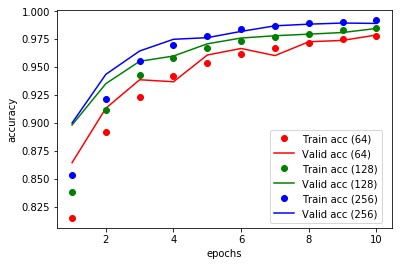

In [49]:
kind_tile = 34
num_hand = 14
x_path = 'data/state_list_tenho_232155.npy'
y_path = 'data/is_win_list_tenho_232155.npy'
history = dense_train_ver3(kind_tile, num_hand, 10, x_path, y_path)

In [44]:
model = load_model('models/dense_34_14.h5')
kind_tile = 34
state_tenho_list = np.load('data/state_list_tenho_109263.npy')
is_win_tenho_list = np.load('data/is_win_list_tenho_109263.npy')
hists = states2hists(state_tenho_list[:len(state_tenho_list) // 10], kind_tile)
onehots = hists2onehots(hists, kind_tile)
y = is_win_tenho_list[:len(state_tenho_list) // 10]
model.evaluate(x=onehots, y=y)

10926/10926 [==============================] - 1s 46us/step


[1.2106214848008945, 0.6280431997071206]

In [46]:
correct_num = 0
incorrect_num = 0
for i, p in enumerate(pred):
    if (p <= 0.5 and y[i] == False) or (p > 0.5 and y[i]):
        correct_num += 1
    else:
        incorrect_num += 1
        #print(p, hists[i])
print(correct_num)
print(incorrect_num)

10653
273


In [49]:
model = load_model('models/dense_34_14.h5')
kind_tile = 34
state_list = [(0,0,0,1,1,1,2,2,2,3,3,3,4,6), (0,1,2,3,4,6,12,13,14,15,15,15,31,31), (1,1,1,24,24,24,26,26,26,30,30,30,33,33)]
is_win_list = [False, False, True]
hists = states2hists(state_list, kind_tile)
onehots = hists2onehots(hists, kind_tile)
model.evaluate(x=onehots, y=is_win_list)

3/3 [==============================] - 0s 58ms/step


[5.21112342931684, 0.3333333333333333]

In [67]:
kind_tile = 9
num_hand = 14

# onehotにする方法
x = np.load('data/state_list_9_14_100000_0.3.npy')
for i in range(3):
    a = np.identity(kind_tile)[x[i]]
    print(a)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 

In [68]:
a = np.identity(kind_tile)[x]
a

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0.

In [10]:
tenho_list = np.load('data/state_list_tenho_109263.npy')

In [11]:
is_win_list = []
kind_tile = 34
for state in tenho_list:
    val = win_split_main(state2hist(state, kind_tile))[0]
    is_win_list.append(val)

In [12]:
sum(is_win_list)

2603

In [13]:
sum(is_win_list) / len(is_win_list)

0.02382325215306188

In [14]:
np.save('data/is_win_list_tenho_109263', is_win_list)

In [17]:
def state_list2is_win_list(num):
    tenho_list = np.load('data/state_list_tenho_{}.npy'.format(num))
    is_win_list = []
    kind_tile = 34
    for state in tenho_list:
        val = win_split_main(state2hist(state, kind_tile))[0]
        is_win_list.append(val)
    print('number of True', sum(is_win_list))
    print('rate of True', sum(is_win_list) / len(is_win_list))
    np.save('data/is_win_list_tenho_{}.npy'.format(num), is_win_list)

In [18]:
state_list2is_win_list(109263)

number of True 2603
rate of True 0.02382325215306188


In [21]:
state_list2is_win_list(119107)

number of True 22818
rate of True 0.19157564206973562


In [30]:
state_list2is_win_list(232155)

number of True 43488
rate of True 0.18732312463655748
